In [1]:
using LinearAlgebra
using Distributions
using Optim
using Random
using StatsFuns
using JuMP
using MosekTools
using StatsBase
using SparseArrays # 可选，用于处理稀疏性（如果数据量很大）
using FileIO
using JLD2
using Plots
using LaTeXStrings
using DataFrames, Colors
using StatsPlots   # 提供 boxplot，基于 Plots

include("Params_PP.jl")
include("Data_Generation_PP.jl")
include("Estimation_PP.jl")
include("Evaluation_PP.jl")
# # include("Plot_Figures.jl")
include("Implement_All_Methods_PP.jl")
include("Models_PP.jl")

Solve_RO_Compact (generic function with 1 method)

## Functions

In [2]:
function Generate_Input_this(S_train, N, N_u, K, offdiag_sign,max_offdiag,P_bar,is_original_setting,is_ridge,lambda)
    Input_Data_this = Dict()

    w_true = Generate_Coef_Wide_Format(N_u, N, max_offdiag, offdiag_sign,is_original_setting);
    choice_sample,Feature_sample = Generate_Data_Wide_Format(N,N_u,S_train,w_true,P_bar);

    w_hat,obj_val,sol_status,solve_time = Estimate_OPT_Model(Feature_sample,choice_sample,is_ridge,lambda);

    Input_Data_this["w_true"] = w_true;
    Input_Data_this["P_dag"] = round.(rand(N, K) .* P_bar; digits=2);
    Input_Data_this["choice_sample"] = choice_sample;
    Input_Data_this["Feature_sample"] = Feature_sample;
    Input_Data_this["w_hat"] = w_hat

    return Input_Data_this
end

Generate_Input_this (generic function with 1 method)

In [ ]:
function Get_Input_Data(Input_Data_this)
    w_true = Input_Data_this["w_true"]
    P_dag = Input_Data_this["P_dag"]
    w_hat = Input_Data_this["w_hat"]
    return w_true,w_hat,P_dag
end

Get_Input_Data (generic function with 1 method)

In [4]:
function solve_ETO_this(N,K,w,w_true,P_dag,Time_Limit)
    RST_this = Dict()
    status_this = "NotDefined"
    # obj_,X_,Promo_, time_,status_ = Solve_ETO(N,N_u,K,A, B,P_dag,Time_Limit)
    obj_, X_,Promo_,time_,status_ = Solve_ETO_Compact(N,K,w,P_dag,Time_Limit)

    if status_ != "OPTIMAL"
        status_this = status_
    else
        status_this = status_
        rev_, price_ = compute_oof_compact(X_, Promo_,w_true,P_dag)

        RST_this["obj"] = obj_
        RST_this["price"] = price_
        RST_this["promo"] = Promo_
        RST_this["time"] = time_
        RST_this["Rev"] = rev_
        RST_this["status"] = status_
    end
    return RST_this,status_this
end

solve_ETO_this (generic function with 1 method)

In [5]:
function solve_RO_this(N,K,w,w_true,P_dag,psi_lb,psi_ub,phi_lb,phi_ub,gamma_list,dual_norm,Time_Limit)
    RST_this = Dict()
    status_this = "NotDefined"
    for gamma in gamma_list
        obj_RO,X_RO,Promo_RO, time_RO,status_RO = Solve_RO_Compact(N,K,w,P_dag,psi_lb,psi_ub,phi_lb,phi_ub,gamma,dual_norm,Time_Limit)

        println("gamma=$(gamma),status:",status_RO,",time=$time_RO")
        if status_RO != "OPTIMAL"
            status_this = status_RO
            break
        else
            status_this = status_RO
            rev_RO, price_RO = compute_oof_compact(X_RO, Promo_RO,w_true,P_dag)

            RST_this["obj_gamma=$(gamma)"] = obj_RO
            RST_this["price_gamma=$(gamma)"] = price_RO
            RST_this["promo_gamma=$(gamma)"] = Promo_RO
            RST_this["time_gamma=$(gamma)"] = time_RO
            RST_this["Rev_gamma=$(gamma)"] = rev_RO
            RST_this["status"] = status_this
        end
    end
    return RST_this,status_this
end

solve_RO_this (generic function with 1 method)

#### Parameters

In [6]:
Params = get_default_params_PP()
seed = Params["seed"]
N = Params["N"]
N_u = Params["N_u"] 
K = Params["K"] 
S_train = Params["S_train"]
S_test = Params["S_test"]
P_bar = Params["P_bar"]
iterations = Params["iterations"]
offdiag_sign = Params["offdiag_sign"]
max_offdiag = Params["max_offdiag"]
Time_Limit = Params["Time_Limit"]
gamma_list = Params["gamma_list"]
dual_norm = Params["dual_norm"]
psi_lb = Params["psi_lb"]
psi_ub = Params["psi_ub"]
phi_lb = Params["phi_lb"]
phi_ub = Params["phi_ub"]

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [7]:
is_original_setting = true
Random.seed!(seed)

project_dir = "Joint_Pricing_and_Promotion_ECP_Estimation/"
current_dir = pwd()
parent_dir = dirname(current_dir)
grand_pa_dir = dirname(parent_dir)
data_dir = string(dirname(grand_pa_dir), "/Data/")
if !isdir(data_dir)
    mkpath(data_dir)
end
if is_original_setting
    sub_file_name = "MS_2024_N=$(N)_N_u=$(N_u)_K=$(K)_S_train=$(S_train)_seed=$(seed)/"
else
    sub_file_name = "N=$(N)_N_u=$(N_u)_K=$(K)_S_train=$(S_train)_offdiag_sign=$(offdiag_sign)_max_offdiag=$(max_offdiag)_seed=$(seed)_Ridge/"
end
this_data_file = string(data_dir,project_dir,sub_file_name)
if !isdir(this_data_file)
    mkpath(this_data_file)
end
println(this_data_file)
save(string(this_data_file, "Params.jld2"), Params);

/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Joint_Pricing_and_Promotion_ECP_Estimation/MS_2024_N=3_N_u=1_K=30_S_train=50_seed=3/


In [8]:
is_ridge = false
lambda = 0.0
Result_All = Dict()
iter = 1
while iter <= iterations
    t_start = time()  # 记录开始时间
    Input_Data_this = Generate_Input_this(S_train, N, N_u, K, offdiag_sign,max_offdiag,P_bar,is_original_setting,is_ridge,lambda);
    w_true,w_hat,P_dag = Get_Input_Data(Input_Data_this);
    
    if any(isnan, w_hat)|| norm(w_true .- w_hat,2) >= 10
        println("Estimate contains NaN values")
        continue
    end
    Result_All["Input_Data_iter=$(iter)"] = Input_Data_this

    RST_Oracle,status_Oracle = solve_ETO_this(N,K,w_true,w_true,P_dag,Time_Limit)
    println("Oracle: status = ",status_Oracle,",time=",RST_Oracle["time"])
    if status_Oracle != "OPTIMAL"
        println("Oracle did not approach the optimal solution")
        continue
    end
    Result_All["RST_Oracle_iter=$(iter)"] = RST_Oracle

    RST_ETO,status_ETO = solve_ETO_this(N,K,w_hat,w_true,P_dag,Time_Limit)
    println("ETO: status = ",status_ETO,",time=",RST_ETO["time"])
    if status_ETO != "OPTIMAL"
        println("ETO did not approach the optimal solution")
        continue
    end
    Result_All["RST_ETO_iter=$(iter)"] = RST_ETO
    

    obj_RO,X_RO,Promo_RO, time_RO,status_RO = Solve_RO_Compact(N,K,w_hat,P_dag,psi_lb,psi_ub,phi_lb,phi_ub,0.0,dual_norm,Time_Limit)
    if status_RO != "OPTIMAL"
        println("RO did not approach the optimal solution")
        continue
    end
    rev_RO, price_RO = compute_oof_compact(X_RO, Promo_RO,w_true,P_dag)
    if abs(rev_RO - RST_ETO["Rev"]) >= 0.001
        println("ETO rev is not equivalent to RO rev")
        continue
    end

    RST_RO,status_RO = solve_RO_this(N,K,w_hat,w_true,P_dag,psi_lb,psi_ub,phi_lb,phi_ub,gamma_list,dual_norm,Time_Limit);
    # println("RO status = ",status_RO)
    if status_RO != "OPTIMAL"
        println("RO did not approach the optimal solution")
        continue
    end
    Result_All["RST_RO_iter=$(iter)"] = RST_RO
    save(string(this_data_file, "Result_All.jld2"), Result_All);
    t_end = time()  # 记录结束时间
    println("******* Time for iter $iter: ", round(t_end - t_start, digits=2), " seconds *********")
    iter = iter + 1
end
save(string(this_data_file, "Result_All_lambda=$(lambda).jld2"), Result_All);

Oracle: status = OPTIMAL,time=0.8102378845214844
ETO: status = OPTIMAL,time=0.9284000396728516
gamma=0.0,status:OPTIMAL,time=51.26753497123718
gamma=0.005,status:OPTIMAL,time=61.675647020339966
gamma=0.01,status:OPTIMAL,time=36.18713712692261
gamma=0.015,status:OPTIMAL,time=27.644032955169678
gamma=0.02,status:OPTIMAL,time=29.62521982192993
gamma=0.03,status:OPTIMAL,time=24.18541383743286
gamma=0.04,status:OPTIMAL,time=26.15731406211853
gamma=0.06,status:OPTIMAL,time=29.054564952850342
gamma=0.08,status:OPTIMAL,time=28.114891052246094
******* Time for iter 1: 376.84 seconds *********
Estimate contains NaN values
Oracle: status = OPTIMAL,time=0.6971480846405029
ETO: status = OPTIMAL,time=0.8255131244659424
gamma=0.0,status:OPTIMAL,time=30.899751901626587
gamma=0.005,status:OPTIMAL,time=27.028741121292114
gamma=0.01,status:OPTIMAL,time=36.20196318626404
gamma=0.015,status:OPTIMAL,time=21.23868989944458
gamma=0.02,status:OPTIMAL,time=20.825244903564453
gamma=0.03,status:OPTIMAL,time=27.91

In [9]:
# Result_All = load(string(this_data_file, "Result_All_lambda=$(lambda).jld2"));

In [10]:
iter = 1
RST_RO_iter = Result_All["RST_RO_iter=$(iter)"]
gamma_list = sort([parse(Float64, split(k, "=")[end]) for k in keys(RST_RO_iter) if startswith(k, "Rev_gamma=")])
println("Gamma list: ", gamma_list)

Gamma list: [0.0, 0.005, 0.01, 0.015, 0.02, 0.03, 0.04, 0.06, 0.08]


In [11]:
Rev_Oracle = [Result_All["RST_Oracle_iter=$(iter)"]["Rev"] for iter in 1:iterations]
Rev_ETO = [Result_All["RST_ETO_iter=$(iter)"]["Rev"] for iter in 1:iterations]
Rev_RO = zeros(iterations,length(gamma_list))
for iter in 1:iterations
    RST_RO = Result_All["RST_RO_iter=$(iter)"]
    for g_index in 1:length(gamma_list)
        gamma = gamma_list[g_index]
        Rev_RO[iter,g_index] = RST_RO["Rev_gamma=$(gamma)"]
    end
end
println("Rev_ETO/Rev_Oracle = ",round.(Rev_ETO./Rev_Oracle,digits=4))
println("Rev_RO/Rev_Oracle = ",round.(Rev_RO[:,1]./Rev_Oracle,digits=4))
println("Rev_ETO/Rev_Oracle = ",mean(Rev_ETO)/mean(Rev_Oracle))

Rev_ETO/Rev_Oracle = [0.9992, 0.959, 0.993, 0.996, 0.8603, 0.9777, 0.9983, 0.8287, 0.9827, 0.9753, 0.9719, 0.9727, 0.981, 0.7175, 0.9746, 0.9335, 0.9735, 0.7252, 0.9356, 0.6302]
Rev_RO/Rev_Oracle = [0.9992, 0.959, 0.993, 0.996, 0.8603, 0.9777, 0.9983, 0.8287, 0.9827, 0.9753, 0.9719, 0.9727, 0.981, 0.7175, 0.9746, 0.9335, 0.9735, 0.7252, 0.9356, 0.6302]
Rev_ETO/Rev_Oracle = 0.9192850057246154


In [12]:
RO_ETO_Ratio_Mean = zeros(length(gamma_list))
RO_ETO_Ratio_Std = zeros(length(gamma_list))
for g_index in 1:length(gamma_list)
    gamma = gamma_list[g_index]
    RO_ETO_Ratio_Mean[g_index] = mean(Rev_RO[:,g_index])/mean(Rev_ETO)
    RO_ETO_Ratio_Std[g_index] = std(Rev_RO[:,g_index])/std(Rev_ETO)
    println("gamma=$gamma,Mean =",RO_ETO_Ratio_Mean[g_index],", Std =",RO_ETO_Ratio_Std[g_index])
end

gamma=0.0,Mean =1.0000004995308491, Std =1.0000021875325442
gamma=0.005,Mean =1.0027067553499247, Std =0.9528062640852888
gamma=0.01,Mean =0.9973344306197484, Std =0.9072225328337632
gamma=0.015,Mean =0.9914197923259226, Std =0.8763806100959689
gamma=0.02,Mean =0.976502699585996, Std =0.9324795271221447
gamma=0.03,Mean =0.9584943170525425, Std =0.8787446109639597
gamma=0.04,Mean =0.936580273404237, Std =0.8678704136699926
gamma=0.06,Mean =0.8939644358593873, Std =0.7592253755318719
gamma=0.08,Mean =0.8708821845716119, Std =0.6559460477412732


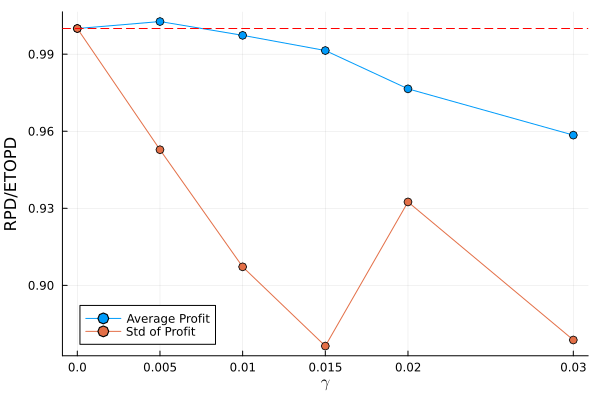

"/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Joint_Pricing_and_Promotion_ECP_Estimation/MS_2024_N=3_N_u=1_K=30_S_train=50_seed=3/RPP_vs_ETOPP.pdf"

In [13]:
end_index = length(gamma_list) - 3
plot(gamma_list[1:end_index], RO_ETO_Ratio_Mean[1:end_index], marker=:o, xlabel=L"\gamma", label="Average Profit", xticks=(gamma_list[1:end_index], string.(gamma_list[1:end_index])))
plot!(gamma_list[1:end_index], RO_ETO_Ratio_Std[1:end_index], marker=:o, xlabel=L"\gamma", ylabel="RPD/ETOPD", label="Std of Profit")
hline!([1.0], linestyle=:dash, color=:red, label="")
display(current())
savefig(string(this_data_file, "RPP_vs_ETOPP.pdf"))

In [14]:
# chosen_indices = [1,2,3,4]
# gamma_chosen = gamma_list[chosen_indices]
# data = [Rev_ETO./mean(Rev_ETO), [Rev_RO[:,ind]./mean(Rev_ETO) for ind in chosen_indices]...]
# labels = ["ETO"; ["RO($gamma)" for gamma in gamma_chosen]]
# # --- 1) 展开成长表 ---
# df = DataFrame(
#     value = vcat(data...),
#     group = repeat(labels, inner = length(data[1]))
# )

# mycolors = palette(:tab10)[1:length(labels)]   # tab10 最多10个颜色
# mycolors = ["#f47e20","#f59898","#1f78b4","#329f48","#6b3e97","#d2ab82","#f47e20"]
# # --- 3) 绘制箱线图 ---
# @df df boxplot(:group, :value;
#     group = :group,
#     palette = mycolors,
#     legend = false,
#     ylabel = "Normalized Revenue",
#     # title = "Revenue Distribution"
# )

# # --- 4) 计算均值 ---
# means = combine(groupby(df, :group), :value => mean => :mean_val)

# for i in 1:length(labels)
#     scatter!([labels[i]], [means.mean_val[i]];
#         color = :red,
#         marker = (:star, 10),
#         label = "")
# end

# # # # --- 6) 绘制均值连线（这里必须把类别转为数值 1:N） ---
# # plot!(labels, means.mean_val;
# #     seriestype = :line,
# #     color = :red,
# #     lw = 2,
# #     ls = :dash,
# #     label = "Mean trend"
# # )
# display(current())
# savefig(string(this_data_file, "RPP_vs_ETOPP_BoxPlot.pdf"))

In [15]:
# bad_idx = findall(i -> abs(Rev_ETO[i] - Rev_RO[i,1]) > 0.01, 1:length(Rev_ETO));
# keep_idx = setdiff(1:length(Rev_ETO), bad_idx);
# Rev_ETO_clean = Rev_ETO[keep_idx];
# Rev_Oracle_clean = Rev_Oracle[keep_idx];
# Rev_RO_clean = Rev_RO[keep_idx, :];
# RO_ETO_Ratio_Mean = zeros(length(gamma_list))
# RO_ETO_Ratio_Std = zeros(length(gamma_list))
# for g_index in 1:length(gamma_list)
#     gamma = gamma_list[g_index]
#     RO_ETO_Ratio_Mean[g_index] = mean(Rev_RO_clean[:,g_index])/mean(Rev_ETO_clean)
#     RO_ETO_Ratio_Std[g_index] = std(Rev_RO_clean[:,g_index])/std(Rev_ETO_clean)
#     println("gamma=$gamma,Mean =",RO_ETO_Ratio_Mean[g_index],", Std =",RO_ETO_Ratio_Std[g_index])
# end
# println("Rev_ETO/Rev_Oracle = ",mean(Rev_ETO_clean)/mean(Rev_Oracle_clean))

In [16]:
# end_index = length(gamma_list) -1
# plot(gamma_list[1:end_index], RO_ETO_Ratio_Mean[1:end_index], marker=:o, xlabel=L"\gamma", label="Average Profit", xticks=(gamma_list[1:end_index], string.(gamma_list[1:end_index])))
# plot!(gamma_list[1:end_index], RO_ETO_Ratio_Std[1:end_index], marker=:o, xlabel=L"\gamma", ylabel="RPD/ETOPD", label="Std of Profit")
# hline!([1.0], linestyle=:dash, color=:red, label="")
# display(current())
# savefig(string(this_data_file, "RPP_vs_ETOPP_Clean.pdf"))